In [1]:
import os
import sys
import numpy as np
from numpy.random import RandomState, SeedSequence, MT19937
import matplotlib.pyplot as plt

powerfactory_path = r'C:\Program Files\DIgSILENT\PowerFactory 2020 SP4\Python\3.8'
if powerfactory_path not in sys.path:
    sys.path.append(powerfactory_path)
import powerfactory as pf

from pfcommon import *

In [2]:
app = pf.GetApplication()
if app is None:
    raise Exception('Cannot get PowerFactory application')
else:
    print('Successfully obtained PowerFactory application.')

Successfully obtained PowerFactory application.


In [3]:
project_name = '\\Terna_Inerzia\\39 Bus New England System'
err = app.ActivateProject(project_name)
if err:
    raise Exception(f'Cannot activate project {project_name}')
print(f'Successfully activated project {project_name}.')

Successfully activated project \Terna_Inerzia\39 Bus New England System.


In [4]:
project = app.GetActiveProject()
if project is None:
    raise Exception('Cannot get active project')
print('Successfully obtained active project.')

Successfully obtained active project.


In [5]:
project_folders = {}
for folder_name in ('study',):
    project_folders[folder_name] = app.GetProjectFolder(folder_name)
    if project_folders[folder_name] is None:
        raise Exception(f'No folder "{folder_name}" present')
    print(f'Successfully obtained folder "{folder_name}".')

Successfully obtained folder "study".


In [6]:
generators = app.GetCalcRelevantObjects('*.ElmSym')
lines = app.GetCalcRelevantObjects('*.ElmLne')
buses = app.GetCalcRelevantObjects('*.ElmTerm')
loads = app.GetCalcRelevantObjects('*.ElmLod')
n_generators, n_lines, n_buses, n_loads = len(generators), len(lines), len(buses), len(loads)
print(f'There are {n_generators} generators.')
print(f'There are {n_lines} lines.')
print(f'There are {n_buses} buses.')
print(f'There are {n_loads} loads.')

There are 10 generators.
There are 34 lines.
There are 39 buses.
There are 19 loads.


In [7]:
for line in lines:
    line_type = line.GetAttribute('typ_id')
    vrating = line_type.GetAttribute('uline')
    print(f'{line.loc_name}: Vrating = {vrating:6.1f} kV.')

Line 01 - 02: Vrating =  345.0 kV.
Line 01 - 39: Vrating =  345.0 kV.
Line 02 - 03: Vrating =  345.0 kV.
Line 02 - 25: Vrating =  345.0 kV.
Line 03 - 04: Vrating =  345.0 kV.
Line 03 - 18: Vrating =  345.0 kV.
Line 04 - 05: Vrating =  345.0 kV.
Line 04 - 14: Vrating =  345.0 kV.
Line 05 - 06: Vrating =  345.0 kV.
Line 05 - 08: Vrating =  345.0 kV.
Line 06 - 07: Vrating =  345.0 kV.
Line 06 - 11: Vrating =  345.0 kV.
Line 07 - 08: Vrating =  345.0 kV.
Line 08 - 09: Vrating =  345.0 kV.
Line 09 - 39: Vrating =  345.0 kV.
Line 10 - 11: Vrating =  345.0 kV.
Line 10 - 13: Vrating =  345.0 kV.
Line 13 - 14: Vrating =  345.0 kV.
Line 14 - 15: Vrating =  345.0 kV.
Line 15 - 16: Vrating =  345.0 kV.
Line 16 - 17: Vrating =  345.0 kV.
Line 16 - 19: Vrating =  345.0 kV.
Line 16 - 21: Vrating =  345.0 kV.
Line 16 - 24: Vrating =  345.0 kV.
Line 17 - 18: Vrating =  345.0 kV.
Line 17 - 27: Vrating =  345.0 kV.
Line 21 - 22: Vrating =  345.0 kV.
Line 22 - 23: Vrating =  345.0 kV.
Line 23 - 24: Vratin

In [8]:
P = {}
S = {}
H = {}
for generator in generators:
    i = int(generator.loc_name.split(' ')[1])
    generator_type = generator.GetAttribute('typ_id')
    P[i] = generator.GetAttribute('pgini')
    S[i] = generator_type.GetAttribute('sgn')
    H[i] = generator_type.GetAttribute('h')
    print(f'{generator.loc_name}: P = {P[i]:4.0f} MW, S = {S[i]:5.0f} MVA, inertia = {H[i]:5.2f} s.')

G 01: P = 1000 MW, S = 10000 MVA, inertia =  5.00 s.
G 02: P =    0 MW, S =   700 MVA, inertia =  4.33 s.
G 03: P =  650 MW, S =   800 MVA, inertia =  4.47 s.
G 04: P =  632 MW, S =   800 MVA, inertia =  3.57 s.
G 05: P =  254 MW, S =   300 MVA, inertia =  4.33 s.
G 06: P =  650 MW, S =   800 MVA, inertia =  4.35 s.
G 07: P =  560 MW, S =   700 MVA, inertia =  3.77 s.
G 08: P =  540 MW, S =   700 MVA, inertia =  3.47 s.
G 09: P =  830 MW, S =  1000 MVA, inertia =  3.45 s.
G 10: P =  250 MW, S =  1000 MVA, inertia =  4.20 s.


In [9]:
areas_map = {
    1: [2, 3, 10],
    2: [4, 5, 6, 7],
    3: [8, 9],
    4: [1]
}
Harea = {}   # inertia
Earea = {}   # energy
Marea = {}   # momentum
for area_id,generator_ids in areas_map.items():
    #Harea[area_id], Earea[area_id], Marea[area_id] = 0, 0, 0
    num, den = 0,0
    for generator_id in generator_ids:
        num += S[generator_id] * H[generator_id]
        den += S[generator_id]
    Harea[area_id] = num / den 
    Earea[area_id] = num * 1e-3
    Marea[area_id] = 2 * num * 1e-3 / 60
print('Area inertias:  [{}] s.'.format(', '.join(list(map(lambda s: f'{s:5.2f}', Harea.values())))))
print('Area energies:  [{}] GW s.'.format(', '.join(list(map(lambda s: f'{s:5.2f}', Earea.values())))))
print('Area momentums: [{}] GW s^2.'.format(', '.join(list(map(lambda s: f'{s:5.2f}', Marea.values())))))

Area inertias:  [ 4.32,  3.95,  3.46,  5.00] s.
Area energies:  [10.81, 10.28,  5.88, 50.00] GW s.
Area momentums: [ 0.36,  0.34,  0.20,  1.67] GW s^2.


## Load flow analysis

In [10]:
study_case_name = '1. Power Flow'
study_case = project_folders['study'].GetContents(study_case_name)[0]
err = study_case.Activate() # don't know why this returns 1
# if err:
#     raise Exception(f'Cannot activate study case {study_case_name}')
print(f'Successfully activated study case {study_case_name}.')

Successfully activated study case 1. Power Flow.


In [11]:
load_flow = app.GetFromStudyCase('ComLdf')
err = load_flow.Execute()
if err:
    raise Exception(f'Cannot run load flow')
print(f'Successfully run load flow.')

Successfully run load flow.


In [12]:
Ptot = 0
Qtot = 0
for gen in generators:
    P = gen.GetAttribute('m:Psum:bus1')
    Q = gen.GetAttribute('m:Qsum:bus1')
    I = gen.GetAttribute('m:I:bus1')
    Ptot += P
    Qtot += Q
    print(f'{gen.loc_name}: P = {P:7.2f} MW, Q = {Q:6.2f} MVAR, I = {I:6.3f} kA.')
print(f'Total P = {Ptot*1e-3:5.2f} GW, total Q = {Qtot*1e-3:5.2f} GVAR')

G 01: P = 1000.00 MW, Q =  88.28 MVAR, I =  1.631 kA.
G 02: P =  520.81 MW, Q = 198.25 MVAR, I = 19.857 kA.
G 03: P =  650.00 MW, Q = 205.14 MVAR, I = 24.260 kA.
G 04: P =  632.00 MW, Q = 109.91 MVAR, I = 22.509 kA.
G 05: P =  508.00 MW, Q = 165.76 MVAR, I = 18.471 kA.
G 06: P =  650.00 MW, Q = 212.41 MVAR, I = 22.804 kA.
G 07: P =  560.00 MW, Q = 101.18 MVAR, I = 18.723 kA.
G 08: P =  540.00 MW, Q =   0.44 MVAR, I = 18.384 kA.
G 09: P =  830.00 MW, Q =  22.84 MVAR, I = 28.303 kA.
G 10: P =  250.00 MW, Q = 146.16 MVAR, I =  9.674 kA.
Total P =  6.14 GW, total Q =  1.25 GVAR


In [13]:
Ptot = 0
Qtot = 0
for load in loads:
    P = load.GetAttribute('m:Psum:bus1')
    Q = load.GetAttribute('m:Qsum:bus1')
    I = load.GetAttribute('m:I:bus1')
    V = load.GetAttribute('m:U1:bus1')    # line-to-ground voltage
    Vl = load.GetAttribute('m:U1l:bus1')  # line-to-line voltage
    Ptot += P
    Qtot += Q
    print(f'{load.loc_name}: P = {P:7.2f} MW, Q = {Q:6.2f} MVAR, I = {I:6.3f} kA, V = {V:8.3f} kV.')
print(f'Total P = {Ptot*1e-3:5.2f} GW, total Q = {Qtot*1e-3:5.2f} GVAR')

Load 04: P =  500.00 MW, Q = 184.00 MVAR, I =  0.888 kA, V =  199.955 kV.
Load 07: P =  233.80 MW, Q =  84.00 MVAR, I =  0.417 kA, V =  198.589 kV.
Load 08: P =  522.00 MW, Q = 176.00 MVAR, I =  0.926 kA, V =  198.393 kV.
Load 12: P =    7.50 MW, Q =  88.00 MVAR, I =  0.369 kA, V =   79.686 kV.
Load 15: P =  320.00 MW, Q = 153.00 MVAR, I =  0.585 kA, V =  202.250 kV.
Load 16: P =  329.00 MW, Q =  32.30 MVAR, I =  0.536 kA, V =  205.515 kV.
Load 18: P =  158.00 MW, Q =  30.00 MVAR, I =  0.261 kA, V =  205.347 kV.
Load 20: P =  628.00 MW, Q = 103.00 MVAR, I =  1.612 kA, V =  131.619 kV.
Load 21: P =  274.00 MW, Q = 115.00 MVAR, I =  0.482 kA, V =  205.512 kV.
Load 23: P =  247.50 MW, Q =  84.60 MVAR, I =  0.419 kA, V =  208.107 kV.
Load 24: P =  308.60 MW, Q = -92.20 MVAR, I =  0.520 kA, V =  206.618 kV.
Load 25: P =  224.00 MW, Q =  47.20 MVAR, I =  0.362 kA, V =  210.652 kV.
Load 26: P =  139.00 MW, Q =  17.00 MVAR, I =  0.223 kA, V =  209.559 kV.
Load 27: P =  281.00 MW, Q =  75.50 MV

In [14]:
power_types = ['gen','load','flow','out']
print('Power types: (' + ' '.join(power_types) + ')')
for bus in buses:
    P = {power_type: bus.GetAttribute(f'm:P{power_type}') for power_type in power_types}
    Q = {power_type: bus.GetAttribute(f'm:Q{power_type}') for power_type in power_types}
    V = bus.GetAttribute('m:U')
    Pline = ' '.join([f'{P[power_type]:6.1f}' for power_type in power_types])
    Qline = ' '.join([f'{Q[power_type]:6.1f}' for power_type in power_types])
    print(f'{bus.loc_name}: V = {V:8.3f} kV, (' + Pline + ') MW, (' + Qline + ') MVar')

Power types: (gen load flow out)
Bus 01: V =  208.619 kV, (   0.0    0.0  124.3  124.3) MW, (   0.0    0.0   28.3   28.3) MVar
Bus 02: V =  208.893 kV, (   0.0    0.0  489.1  489.1) MW, (   0.0    0.0  174.9   49.6) MVar
Bus 03: V =  205.196 kV, (   0.0  322.0  414.9  414.9) MW, (   0.0    2.4  113.0  113.0) MVar
Bus 04: V =  199.955 kV, (   0.0  500.0  500.0  500.0) MW, (   0.0  184.0  184.0  184.0) MVar
Bus 05: V =  200.244 kV, (   0.0    0.0  454.4  454.4) MW, (   0.0    0.0   58.7   55.9) MVar
Bus 06: V =  200.714 kV, (   0.0    0.0  875.5  875.5) MW, (   0.0    0.0  148.5  148.5) MVar
Bus 07: V =  198.589 kV, (   0.0  233.8  419.5  419.5) MW, (   0.0   84.0   86.0   86.0) MVar
Bus 08: V =  198.393 kV, (   0.0  522.0  522.0  522.0) MW, (   0.0  176.0  176.0  176.0) MVar
Bus 09: V =  204.808 kV, (   0.0    0.0   20.1   20.1) MW, (   0.0    0.0   69.9   69.9) MVar
Bus 10: V =  202.602 kV, (   0.0    0.0  650.0  650.0) MW, (   0.0    0.0  109.0  109.0) MVar
Bus 11: V =  201.714 kV, ( 

## Transient stability analysis

In [15]:
study_case_name = '5. Transient Stability'
if '.IntCase' not in study_case_name and False:
    study_case_name += '.IntCase'
study_case = project_folders['study'].GetContents(study_case_name)[0]
err = study_case.Activate() # don't know why this returns 1
# if err:
#     raise Exception(f'Cannot activate study case {study_case_name}')
print(f'Successfully activated study case {study_case_name}.')

Successfully activated study case 5. Transient Stability.


Objects that will be used in the following:

In [16]:
generators = app.GetCalcRelevantObjects('*.ElmSym')
loads = app.GetCalcRelevantObjects('*.ElmLod')
buses = app.GetCalcRelevantObjects('*.ElmTerm')

Find the load that should be stochastic:

In [17]:
stochastic_load_name = 'Load 03'
found = False
for load in loads:
    if load.loc_name == stochastic_load_name:
        stochastic_load = load
        found = True
        print(f'Found load named {stochastic_load_name}.')
        break
if not found:
    raise Exception(f'Cannot find load named {stochastic_load_name}')

composite_model_name = 'Stochastic Load'
found = False
for composite_model in app.GetCalcRelevantObjects('*.ElmComp'):
    if composite_model.loc_name == composite_model_name:
        stochastic_load_model = composite_model
        found = True
        print(f'Found composite model named {composite_model_name}.')
        break
if not found:
    raise Exception(f'Cannot find composite model named {composite_model_name}')

for slot,net_element in zip(stochastic_load_model.pblk, stochastic_load_model.pelm):
    if slot.loc_name == 'load slot':
        net_element = stochastic_load
        print(f'Set {stochastic_load_name} as stochastic load.')

Found load named Load 03.
Found composite model named Stochastic Load.
Set Load 03 as stochastic load.


Find the path of the file containing the dynamics of the stochastic load

In [18]:
measurement_file_obj = app.GetCalcRelevantObjects('*.ElmFile')[0]
stochastic_load_filename = measurement_file_obj.f_name
print(f'The stochastic load file is {stochastic_load_filename}.')

The stochastic load file is C:\Users\Terna_Inerzia\Desktop\PowerFactory\Stochastic_Load.txt.


Write the file with the stochastic load

In [19]:
dt = 1e-3
tend = 10
N = int(tend / dt) + 1
seed = 100
stddev = 5      # [MW]
tau = 100e-3    # [s]
P0 = stochastic_load.plini
Q0 = stochastic_load.qlini
rs = RandomState(MT19937(SeedSequence(seed)))
ou = OU(dt, P0, stddev, tau, N, rs)
tPQ = np.zeros((N,3))
tPQ[:,0] = np.linspace(0, tend, N)
tPQ[:,1] = ou
tPQ[:,2] = Q0
with open(stochastic_load_filename, 'w') as fid:
    fid.write('2\n\n')
    for row in tPQ:
        fid.write(f'{row[0]:.6f}\t{row[1]:.2f}\t{row[2]:.2f}\n\n')

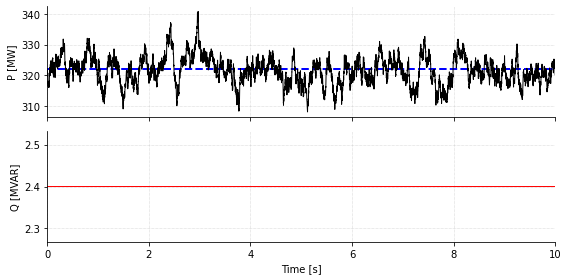

In [20]:
fig,ax = plt.subplots(2, 1, sharex=True, figsize=(8,4))
ax[0].plot([0, tend], P0 + np.zeros(2), 'b--', lw=2)
ax[0].plot(tPQ[:,0], tPQ[:,1], 'k', lw=1)
ax[1].plot(tPQ[:,0], tPQ[:,2], 'r', lw=1)
for a in ax:
    a.grid(which='major', axis='both', lw=0.5, ls=':')
    for side in 'right','top':
        a.spines[side].set_visible(False)
ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('P [MW]')
ax[1].set_ylabel('Q [MVAR]')
ax[0].set_xlim([0,tend])
fig.tight_layout()

In [21]:
monitored_variables = {
    '*.ElmSym': ['s:xspeed'],
    '*.ElmLod': ['m:Psum:bus1', 'm:Qsum:bus1'],
    '*.ElmTerm': ['m:u', 'm:ur', 'm:ui', 'm:u1', 'm:u1r', 'm:u1i', 'm:Pflow', 'm:Qflow', 'm:Pout', 'm:Qout']
}
# the results of the transient simulation will be stored in this variable
res = app.GetFromStudyCase('*.ElmRes')
for elements,var_names in monitored_variables.items():
    for element in app.GetCalcRelevantObjects(elements):
        for var_name in var_names:
            res.AddVariable(element, var_name)

In [22]:
inc = app.GetFromStudyCase('ComInc')
inc.iopt_sim = 'rms'
inc.tstart = 0
inc.dtgrd = dt
err = inc.Execute()
if err:
    raise Exception('Cannot compute initial condition')
print('Successfully computed initial condition.')

Successfully computed initial condition.


In [23]:
sim = app.GetFromStudyCase('ComSim')
sim.tstop = 0.5
sim.dtstop = dt
err = sim.Execute()
if err:
    raise Exception('Cannot run transient simulation')
print('Successfully run transient simulation.')
# app.ResLoadData(res)
res.Load()

Successfully run transient simulation.


Get the data:

In [24]:
dtsim = get_simulation_dt(res)
dec = int(dt // dtsim)

sys.stdout.write('.')
sys.stdout.flush()
time = get_simulation_time(res, decimation=dec)

sys.stdout.write('.')
sys.stdout.flush()
speed = get_simulation_variables(res, 's:xspeed', elements=generators, decimation=dec)

sys.stdout.write('.')
sys.stdout.flush()
P = get_simulation_variables(res, 'm:Psum:bus1', elements=loads, decimation=dec)

sys.stdout.write('.')
sys.stdout.flush()
Q = get_simulation_variables(res, 'm:Qsum:bus1', elements=loads, decimation=dec)

sys.stdout.write('.')
sys.stdout.flush()
V = get_simulation_variables(res, 'm:u', elements=buses, decimation=dec)

sys.stdout.write('.')
sys.stdout.flush()
Vr = get_simulation_variables(res, 'm:ur', elements=buses, decimation=dec)

sys.stdout.write('.')
sys.stdout.flush()
Vi = get_simulation_variables(res, 'm:ui', elements=buses, decimation=dec)

# sys.stdout.write('.')
# sys.stdout.flush()
# Pflow = get_simulation_variables(res, 'm:Pflow', elements=buses, decimation=dec)

# sys.stdout.write('.')
# sys.stdout.flush()
# Qflow = get_simulation_variables(res, 'm:Qflow', elements=buses, decimation=dec)

# sys.stdout.write('.')
# sys.stdout.flush()
# Pout = get_simulation_variables(res, 'm:Pout', elements=buses, decimation=dec)

# sys.stdout.write('.')
# sys.stdout.flush()
# Qout = get_simulation_variables(res, 'm:Qout', elements=buses, decimation=dec)

.......

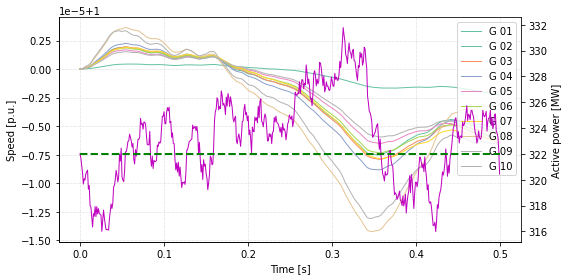

In [25]:
cmap = plt.get_cmap('Set2', n_generators)
fig,ax = plt.subplots(1, 1, figsize=(8,4))
if len(speed.shape) > 1:
    for i,generator in enumerate(generators):
        ax.plot(time, speed[:,i], color=cmap(i), lw=1, label=generator.loc_name)
else:
    ax.plot(time, speed, color='k', lw=1, label=generator.loc_name)
idx, = np.where(tPQ[:,0] < time[-1])
ax2 = ax.twinx()
ax2.plot(tPQ[idx,0], tPQ[idx,1], 'm', lw=1)
ax2.plot(time[[0,-1]], P0 + np.zeros(2), 'g--', lw=2)
ax2.set_ylabel('Active power [MW]')
ax.legend(loc='upper right')
for side in 'right','top':
    ax.spines[side].set_visible(False)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Speed [p.u.]')
ax.grid(which='major', axis='both', lw=0.5, ls=':')
fig.tight_layout()

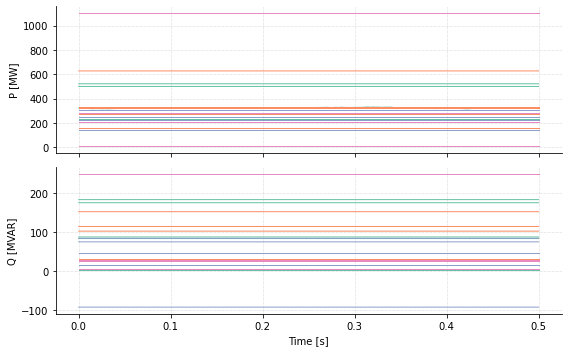

In [26]:
cmap = plt.get_cmap('Set2', len(buses))
fig,ax = plt.subplots(2, 1, figsize=(8,5), sharex=True)
for i,load in enumerate(loads):
    ax[0].plot(time, P[:,i], color=cmap(i), lw=1, label=load.loc_name)
    ax[1].plot(time, Q[:,i], color=cmap(i), lw=1, label=load.loc_name)
# ax[0].legend(loc='upper left')
for a in ax:
    a.grid(which='major', axis='both', lw=0.5, ls=':')
    for side in 'right','top':
        a.spines[side].set_visible(False)
ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('P [MW]')
ax[1].set_ylabel('Q [MVAR]')
fig.tight_layout()

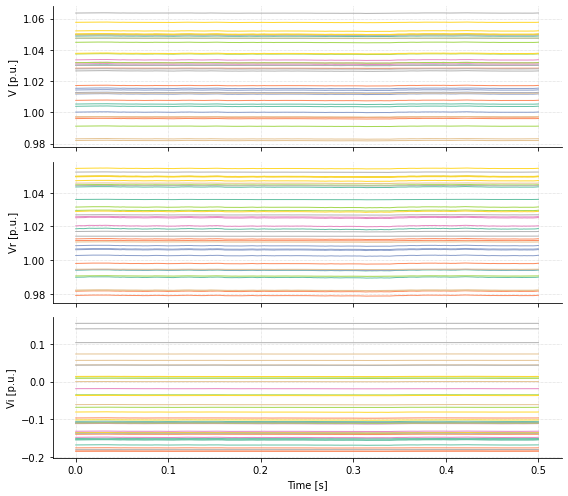

In [27]:
cmap = plt.get_cmap('Set2', len(buses))
fig,ax = plt.subplots(3, 1, figsize=(8,7), sharex=True)
for i,load in enumerate(buses):
    ax[0].plot(time, V[:,i], color=cmap(i), lw=1, label=load.loc_name)
    ax[1].plot(time, Vr[:,i], color=cmap(i), lw=1, label=load.loc_name)
    ax[2].plot(time, Vi[:,i], color=cmap(i), lw=1, label=load.loc_name)
# ax[0].legend(loc='upper left')
for a in ax:
    a.grid(which='major', axis='both', lw=0.5, ls=':')
    for side in 'right','top':
        a.spines[side].set_visible(False)
ax[-1].set_xlabel('Time [s]')
ax[0].set_ylabel('V [p.u.]')
ax[1].set_ylabel('Vr [p.u.]')
ax[2].set_ylabel('Vi [p.u.]')
# ax[1].set_ylim([-0.95,-0.77])
# ax[2].set_ylim([0.4,0.6])
fig.tight_layout()